In [99]:
# Âá∫Ëµ∞È¶¨„Å´„Å§„ÅÑ„Å¶‰∏ä‰Ωç„Å´ÂÖ•„ÇãÁ¢∫Áéá„Çí‰∫àÊÉ≥„Åó„ÄÅÁ¢∫Áéá„ÅåÈñæÂÄ§‰ª•‰∏ä„ÅÆÂ†¥Âêà„Å´Èôê„ÇäË≥ºÂÖ•„Åô„Çã„Åì„Å®„ÇíËÄÉ„Åà„Çã
# ÈñæÂÄ§„Çí‰Ωø„Çè„Åö„Å´Ë≥ºÂÖ•„Åó„ÅüÂ†¥Âêà„Å®ÈñæÂÄ§‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÅßÊØîËºÉ„Åó„ÄÅÁöÑ‰∏≠Áéá„ÇÑÂõûÂèéÁéá„ÅåÊîπÂñÑ„Åï„Çå„Çã„ÅãÁ¢∫Ë™ç„Åô„Çã

In [383]:
# „Ç§„É≥„Éù„Éº„Éà
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
# ! pip install japanize-matplotlib
import japanize_matplotlib
from scipy import stats

In [741]:
# CSV„Éï„Ç°„Ç§„É´„ÅÆË™≠„ÅøËæº„Åø
# df = pd.read_csv('input_Á∑®ÈõÜÂæå.csv', encoding='utf-8')
num_horses = 10
df = pd.read_csv(f'input_{num_horses}È†≠_Á∑®ÈõÜÂæå.csv', encoding='utf-8')
df['race_date'] = pd.to_datetime(df['race_date'])  # Êó•‰ªò„ÅåÊñáÂ≠óÂàó„Å™„ÇâÂ§âÊèõ
print(f"df„ÅÆË°åÊï∞„ÅØ {len(df)} ")
# „É¨„Éº„ÇπID„ÄÅÈ¶¨Áï™È†Ü„Å´‰∏¶„Å≥Êõø„Åà
df = df.sort_values(by=['race_id', 'horse_number'])

df„ÅÆË°åÊï∞„ÅØ 135630 


In [743]:

def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):

    """
    ÂõûÂèéÁéá„ÅÆ‰ø°È†ºÂå∫Èñì„ÇíÊ±Ç„ÇÅ„ÇãÈñ¢Êï∞

    Parameters
    ----------
    mean       : float           Âπ≥ÂùáÂõûÂèéÁéáÔºà‰æãÔºö1.05Ôºâ
    std        : float           Ê®ôÊ∫ñÂÅèÂ∑Æ  Ôºà‰æãÔºö0.15Ôºâ
    n          : int             „Çµ„É≥„Éó„É´Êï∞Ôºà„É¨„Éº„ÇπÊï∞Ôºâ
    confidence : float, optional ‰ø°È†ºÊ∞¥Ê∫ñÔºà„Éá„Éï„Ç©„É´„Éà„ÅØ0.95Ôºâ

    Returns
    -------
    (lower, upper) : tuple of float
        ‰ø°È†ºÂå∫Èñì„ÅÆ‰∏ãÈôêÂÄ§„Å®‰∏äÈôêÂÄ§
    """
    
    # tÂÄ§ÔºàtÂàÜÂ∏É„ÅÆËá®ÁïåÂÄ§Ôºâ
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    
    # ‰ø°È†ºÂå∫Èñì„ÅÆÂπÖÔºà„Éû„Éº„Ç∏„É≥Ôºâ
    margin = t_value * std / np.sqrt(n)
    
    # Âå∫Èñì„ÅÆ‰∏ãÈôê„Éª‰∏äÈôê
    lower = mean - margin
    upper = mean + margin
    
    return lower, upper
    

In [745]:
# === Ê¨†ÊêçÂÄ§ÂØæÂøú„ÅÆË®≠ÂÆö ===
handle_missing = True  # True„ÅßÂØæÂøúON„ÄÅFalse„Åß„Çπ„Ç≠„ÉÉ„Éó
min_non_missing_horses = 10  # „Åì„ÅÆÈ†≠Êï∞‰ª•‰∏ä„Åß„ÅÇ„Çå„Å∞Ë£úÂÆå„ÄÅ„Åù„ÇåÊú™Ê∫Ä„Å™„Çâ„É¨„Éº„Çπ„Åî„Å®Èô§Â§ñ

# Ê¨†ÊêçÂá¶ÁêÜÂØæË±°„ÅÆÁâπÂæ¥Èáè„ÇíÊåáÂÆöÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Êã°ÂºµÔºâ
missing_check_features = [
    'time_index_average_2',
    'jockey_place_rate_100'
]

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("‚ö† Ê¨†ÊêçÂá¶ÁêÜ„ÅØ„Çπ„Ç≠„ÉÉ„Éó„Åï„Çå„Åæ„Åó„Åü„ÄÇ")
        return df

    print("‚úÖ Ê¨†ÊêçÂá¶ÁêÜ„ÇíÈñãÂßã„Åó„Åæ„Åô...")
    valid_race_ids = []
    processed_groups = []

    for race_id, group in df.groupby('race_id'):
        # Ê¨†Êêç„Åå„Å™„ÅÑË°åÊï∞„Çí„Ç´„Ç¶„É≥„Éà
        non_missing_mask = group[features].notnull().all(axis=1)
        non_missing_count = non_missing_mask.sum()

        if non_missing_count < min_horses:
            # ‚Üí ÊåáÂÆöÈ†≠Êï∞Êú™Ê∫Ä ‚Üí Èô§Â§ñ
            continue
        else:
            # ‚Üí ÊåáÂÆöÈ†≠Êï∞‰ª•‰∏ä ‚Üí Âπ≥ÂùáÂÄ§„ÅßË£úÂÆå
            for col in features:
                if group[col].isnull().any():
                    mean_val = group[col].mean(skipna=True)
                    group[col] = group[col].fillna(mean_val)
            processed_groups.append(group)

    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"‚úÖ Ê¨†ÊêçÂá¶ÁêÜÂæå„ÅÆ„É¨„Ç≥„Éº„ÉâÊï∞: {len(df_processed)}ÔºàÂÖÉ: {len(df)}Ôºâ")
    return df_processed

# === Ê¨†ÊêçÂá¶ÁêÜ„ÅÆÂÆüË°å ===
df_not_handle_missing_val = df.copy()
df_handle_missing_val = handle_missing_val(
    df_not_handle_missing_val,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=min_non_missing_horses
)


‚úÖ Ê¨†ÊêçÂá¶ÁêÜ„ÇíÈñãÂßã„Åó„Åæ„Åô...
‚úÖ Ê¨†ÊêçÂá¶ÁêÜÂæå„ÅÆ„É¨„Ç≥„Éº„ÉâÊï∞: 82140ÔºàÂÖÉ: 135630Ôºâ


In [747]:
# ---------- Ë™¨ÊòéÂ§âÊï∞ ----------------------------
df_feature = df_handle_missing_val.copy()
race_avg_time_index = df_feature.groupby('race_id')['time_index_average_2'].transform('mean')
df_feature['time_index_diff_from_avg'] = df_feature['time_index_average_2'] - race_avg_time_index
race_avg_jockey_place_rate = df_feature.groupby('race_id')['jockey_place_rate_100'].transform('mean')
df_feature['jockey_place_rate_diff_from_avg'] = df_feature['jockey_place_rate_100'] - race_avg_jockey_place_rate
features = [
    'time_index_diff_from_avg',
    'jockey_place_rate_diff_from_avg',
]
# ---------- „É™„Éº„ÇØÈò≤Ê≠¢„ÅÆ„É©„Éô„É´‰∏ÄÊã¨‰ΩúÊàê ----------
# ‰∏ä‰Ωç4È†≠ ‚Üí is_top4
df_feature['is_top4'] = (
    df_feature.groupby('race_id')['finish_rank']
    .rank(method='first') <= num_horses / 2 
).astype(int)

In [749]:
# „Éï„Ç£„É´„ÇøÊù°‰ª∂„ÇíÈÅ©Áî®
filtered_df = df_feature.copy()
## Âπ¥
train_year = 2022
valid_year = 2023
if train_year < valid_year:
    min_year = train_year
    max_year = valid_year
else:
    min_year = valid_year
    max_year = train_year
filtered_df = filtered_df[
    (filtered_df['race_date'].dt.year >= min_year) &
    (filtered_df['race_date'].dt.year <= max_year)
]
## ‰∫∫Ê∞ó
# filtered_df = filtered_df[filtered_df['popularity'] == 2]

# „Ç´„Ç¶„É≥„Éà
print(f"filtered_df„ÅÆË°åÊï∞„ÅØ {len(filtered_df)} ")

filtered_df„ÅÆË°åÊï∞„ÅØ 35960 


In [753]:
# ---------- „É¢„Éá„É´1 ----------
df_m1 = filtered_df.copy()

# ---------- ÂêÑ„É¢„Éá„É´„ÅÆÁâπÂæ¥Èáè„Å®ÁõÆÁöÑÂ§âÊï∞ ----------
X_m1 = df_m1[features]
y_m1 = df_m1['is_top4']

X_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_m1.csv', index=False, encoding='cp932')
y_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_m1.csv', index=False, encoding='cp932')

# ---------- „É¢„Éá„É´1„ÅÆÂ≠¶Áøí ----------
X_train_m1 = X_m1[df_m1['race_date'].dt.year == train_year]
y_train_m1 = y_m1[df_m1['race_date'].dt.year == train_year]
X_val_m1   = X_m1[df_m1['race_date'].dt.year == valid_year]
y_val_m1   = y_m1[df_m1['race_date'].dt.year == valid_year]

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model1 = xgb.XGBClassifier(
    **base_params,
    base_score = 0.5,
    max_depth=3,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0
)
model1.fit(X_train_m1, y_train_m1)

X_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_train_m1.csv', index=False, encoding='cp932')
y_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_train_m1.csv', index=False, encoding='cp932')
X_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_val_m1.csv', index=False, encoding='cp932')
y_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_val_m1.csv', index=False, encoding='cp932')

# ============================================================
# ‚úÖ Êé®Ë´ñ„Éï„Çß„Éº„Ç∫Ôºà„É¨„Éº„ÇπÂçò‰Ωç„ÅßÈ†Ü„Å´„É¢„Éá„É´„ÇíÈÅ©Áî®„Åó„Å¶1ÁùÄ„Çí‰∫àÊ∏¨Ôºâ
# ============================================================

# ÂØæË±°„Å®„Åô„ÇãÊ§úË®º„Éá„Éº„Çø„ÅÆ„Åø
df_test = filtered_df[filtered_df['race_date'].dt.year == valid_year].copy()

# ÁµêÊûúÊ†ºÁ¥ç„É™„Çπ„Éà
full_predictions = []

for race_id, group in df_test.groupby('race_id'):

    # ---------- „É¢„Éá„É´1 ----------
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1['pred_prob_m1'] = model1.predict_proba(X_test_m1)[:, 1]
    # ‰∏ä‰Ωç4È†≠„ÇíÈÅ∏Âá∫
    group_m1 = group_m1.sort_values('pred_prob_m1', ascending=False)
    group_m1['selected_in_m1'] = 0
    group_m1.iloc[:int(num_horses / 2), group_m1.columns.get_loc('selected_in_m1')] = 1

    # ‚úÖ finish_rank „ÇÇÂê´„ÇÅ„Å¶Âá∫Âäõ
    result_cols = [
        'race_id', 'course_id', 'num_horses', 'race_number', 'weather_name', 'track_condition_name', 'horse_number', 'finish_rank', 'popularity', 'odds', 'pred_prob_m1', 'selected_in_m1'
    ] + features

    full_predictions.append(group_m1[result_cols])

# ÂÖ®„É¨„Éº„ÇπÁµêÂêà
full_pred_df = pd.concat(full_predictions, ignore_index=True)

# CSVÂá∫Âäõ
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\race_predictions_all_stages.csv', index=False, encoding='cp932')

print("finish_rank „ÇíÂê´„ÇÅ„ÅüÂÖ®ÊÆµÈöé„ÅÆ‰∫àÊ∏¨ÁµêÊûúCSV„ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ")

### „É¢„Éá„É´„ÅÆË©ï‰æ° ###

# „É¢„Éá„É´1
m1_preds = full_pred_df[full_pred_df['selected_in_m1'] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds['finish_rank'] <= 6).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0

# Âá∫Âäõ
print(f"‚ñº „É¢„Éá„É´1Ôºà‰∏ä‰Ωç{int(num_horses / 2)}È†≠‰∫àÊ∏¨Ôºâ„ÅÆÁöÑ‰∏≠Áéá")
print(f"  ‰∫àÊ∏¨Êï∞: {m1_total}, ÁöÑ‰∏≠Êï∞: {m1_hits}, ÁöÑ‰∏≠Áéá: {m1_accuracy:.4f}Ôºà{m1_accuracy:.2%}Ôºâ\n")

# CSVÂá∫Âäõ
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\full_pred_df.csv', index=False, encoding='cp932')

C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:51:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


finish_rank „ÇíÂê´„ÇÅ„ÅüÂÖ®ÊÆµÈöé„ÅÆ‰∫àÊ∏¨ÁµêÊûúCSV„ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ
‚ñº „É¢„Éá„É´1Ôºà‰∏ä‰Ωç5È†≠‰∫àÊ∏¨Ôºâ„ÅÆÁöÑ‰∏≠Áéá
  ‰∫àÊ∏¨Êï∞: 8300, ÁöÑ‰∏≠Êï∞: 6334, ÁöÑ‰∏≠Áéá: 0.7631Ôºà76.31%Ôºâ



In [755]:
# ============================================
# È¶¨Áï™„Åî„Å®„ÅÆ‰∫àÊ∏¨ÁµêÊûú„ÇíÂàÜÊûê
# ============================================

# ÂÆüÈöõ„ÅÆ‰∏ä‰ΩçÔºàfinish_rank <= 6Ôºâ„Çí„Éï„É©„Ç∞Âåñ
full_pred_df['is_actual_top'] = (full_pred_df['finish_rank'] <= num_horses / 2).astype(int)

# ÈõÜË®àÈñ¢Êï∞„ÇíÂÆöÁæ©
def calc_hit_ratio(group):
    upper = group[group['selected_in_m1'] == 1]
    lower = group[group['selected_in_m1'] == 0]

    upper_hit_rate = upper['is_actual_top'].mean() if len(upper) > 0 else None
    lower_hit_rate = lower['is_actual_top'].mean() if len(lower) > 0 else None

    return pd.Series({
        '‰∏ä‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá': upper_hit_rate,
        '‰∏ã‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá': lower_hit_rate,
        '‰∏ä‰Ωç‰∫àÊÉ≥Êï∞': len(upper),
        '‰∏ã‰Ωç‰∫àÊÉ≥Êï∞': len(lower)
    })

# È¶¨Áï™„Åî„Å®„Å´ÈõÜË®à
horse_summary = full_pred_df.groupby('horse_number').apply(calc_hit_ratio).reset_index()

# ÁµêÊûú„ÇíË°®Á§∫
print("üêé È¶¨Áï™„Åî„Å®„ÅÆ‰∏ä‰ΩçÔºè‰∏ã‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá")
print(horse_summary)

# CSV„Å´Âá∫ÂäõÔºà‰ªªÊÑèÔºâ
horse_summary.to_csv('C:\\Users\\ryo\\Downloads\\horse_summary_hit_rate.csv', index=False, encoding='cp932')


üêé È¶¨Áï™„Åî„Å®„ÅÆ‰∏ä‰ΩçÔºè‰∏ã‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá
   horse_number  ‰∏ä‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá  ‰∏ã‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá  ‰∏ä‰Ωç‰∫àÊÉ≥Êï∞  ‰∏ã‰Ωç‰∫àÊÉ≥Êï∞
0             1   0.648780   0.308333  820.0  840.0
1             2   0.655257   0.312352  818.0  842.0
2             3   0.665848   0.302600  814.0  846.0
3             4   0.691610   0.329049  882.0  778.0
4             5   0.663496   0.302808  841.0  819.0
5             6   0.683649   0.327206  844.0  816.0
6             7   0.688172   0.312272  837.0  823.0
7             8   0.691739   0.328622  811.0  849.0
8             9   0.687875   0.336155  833.0  827.0
9            10   0.700000   0.363953  800.0  860.0


C:\Users\ryo\AppData\Local\Temp\ipykernel_8124\1080547014.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  horse_summary = full_pred_df.groupby('horse_number').apply(calc_hit_ratio).reset_index()


In [787]:
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================
# „Ç≥„Éº„Çπ„Åî„Å®„ÅÆÁöÑ‰∏≠ÂÇæÂêëÔºà„É¨„Éº„ÇπÂçò‰Ωç„ÅßË©ï‰æ°Ôºâ
# ===================================================

# target_category = 'course_id'
# target_category = 'weather_name'
target_category = 'race_number'
# target_category = 'track_condition_name'

# ÂÆüÈöõ„Å´‰∏ä‰Ωç„ÅÆÈ¶¨„Éï„É©„Ç∞
full_pred_df['is_actual_top'] = (full_pred_df['finish_rank'] <= num_horses / 2).astype(int)

# „É¨„Éº„Çπ„Åî„Å®„ÅÆÁöÑ‰∏≠ÁéáÔºà‰∏ä‰Ωç‰∫àÊÉ≥È¶¨„ÅÆ‰∏≠„Åß‰ΩïÈ†≠„ÅåÂÆüÈöõ„Å´‰∏ä‰Ωç„Å´ÂÖ•„Å£„Åü„ÅãÔºâ
race_summary = (
    full_pred_df[full_pred_df['selected_in_m1'] == 1]
    .groupby(['race_id', target_category])
    .agg(
        total_predicted=('horse_number', 'count'),
        actual_top_hits=('is_actual_top', 'sum')
    )
    .reset_index()
)

# „Äå„ÅÇ„Åü„ÇäÔºè„ÅØ„Åö„Çå„ÄçÂà§ÂÆö
race_summary['hit_flag'] = (
#    race_summary['actual_top_hits'] >= (race_summary['total_predicted'] / 2)
    race_summary['actual_top_hits'] >= (race_summary['total_predicted'] / 2 + 1)
).astype(int)

# ÈõÜË®à
summary = (
    race_summary.groupby(target_category)
    .agg(
        total_races=('race_id', 'count'),
        hit_races=('hit_flag', 'sum')
    )
    .reset_index()
)
summary['miss_races'] = summary['total_races'] - summary['hit_races']
summary['hit_rate'] = summary['hit_races'] / summary['total_races']
summary['miss_rate'] = 1 - summary['hit_rate']

# Ë°®Á§∫„ÇíÊï¥ÂΩ¢
summary = summary.sort_values('hit_rate', ascending=False)
summary['hit_rate'] = (summary['hit_rate'] * 100).round(1)
summary['miss_rate'] = (summary['miss_rate'] * 100).round(1)

# Âá∫ÂäõË°®Á§∫
print("üèá „Ç≥„Éº„Çπ„Åî„Å®„ÅÆ„Äé„ÅÇ„Åü„ÇäÔºè„ÅØ„Åö„Çå„ÄèÈõÜË®àÁµêÊûúÔºàÔºÖÔºâ\n")
print(summary.to_string(index=False))

# CSV„Å´‰øùÂ≠ò
summary.to_csv('C:\\Users\\ryo\\Downloads\\summary.csv', index=False, encoding='cp932')

print("\n‚úÖ „Ç≥„Éº„Çπ„Åî„Å®„ÅÆÁöÑ‰∏≠Áéá„Å®„ÅØ„Åö„ÇåÁéá„ÇíË°®ÂΩ¢Âºè„ÅßCSVÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ")


üèá „Ç≥„Éº„Çπ„Åî„Å®„ÅÆ„Äé„ÅÇ„Åü„ÇäÔºè„ÅØ„Åö„Çå„ÄèÈõÜË®àÁµêÊûúÔºàÔºÖÔºâ

 race_number  total_races  hit_races  miss_races  hit_rate  miss_rate
           5          153         77          76      50.3       49.7
          12           72         36          36      50.0       50.0
           2          125         61          64      48.8       51.2
           3          157         76          81      48.4       51.6
           7          157         76          81      48.4       51.6
           1          146         70          76      47.9       52.1
           4          153         72          81      47.1       52.9
           9          139         62          77      44.6       55.4
          11          128         57          71      44.5       55.5
           6          146         65          81      44.5       55.5
           8          136         58          78      42.6       57.4
          10          148         57          91      38.5       61.5

‚úÖ „Ç≥„Éº„Çπ„Åî

In [933]:
# ‚ñº Êù°‰ª∂Ë®≠ÂÆöÔºà‰∫∫Ê∞ó„ÄÅ‰∫àÊ∏¨Á¢∫Áéá„ÄÅ„Ç™„ÉÉ„Ç∫Ôºâ
target_popularity = 1
compared_popularity = 2
target_threshold = 0.75
compared_threshold = 0.65

# „Ç™„ÉÉ„Ç∫„ÅÆÊù°‰ª∂„ÇíËøΩÂä†ÔºàÁØÑÂõ≤ÊåáÂÆöÔºâ
min_odds = 1.1   # „Åì„ÅÆÂÄ§‰ª•‰∏ä
max_odds = 10.0  # „Åì„ÅÆÂÄ§‰ª•‰∏ã

# ÂêÑÁ®ÆÊù°‰ª∂ËøΩÂä†
# target_race_numbers = [1, 2, 3, 4, 5, 7, 12]
target_race_numbers = [12]
target_horse_numbers = [6, 7, 8, 9, 10]
target_weather_name = ['Êô¥', 'Êõá', 'Â∞èÈõ®']
'''
target_course_id = [
    401, 504, 808, 500, 406, 405, 403, 402, 706, 1104, 1105, 1106, 1202, 1203, 1310,
    904, 204, 1405, 1400, 804, 100, 802, 1101, 803, 1401, 1406, 601, 1100, 1304, 103,
    202, 502, 600, 203, 200, 106, 1309, 1404, 505, 1402, 1306, 800, 901, 602, 604,
    900, 1302, 102, 702
]
'''

# 1. ÊåáÂÆö‰∫∫Ê∞ó„ÅÆÈ¶¨„Å†„ÅëÊäΩÂá∫
target_df = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# 2. ÊØîËºÉÂØæË±°‰∫∫Ê∞óÔºà‰æãÔºö2Áï™‰∫∫Ê∞óÔºâ„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„ÇíÂèñÂæó
compared_probs = (
    full_pred_df[full_pred_df['popularity'] == compared_popularity]
    .loc[:, ['race_id', 'pred_prob_m1']]
    .rename(columns={'pred_prob_m1': f'pop{compared_popularity}_prob'})
)

# 3. „Éû„Éº„Ç∏Ôºà„É¨„Éº„ÇπÂçò‰Ωç„ÅßÊØîËºÉÂØæË±°„ÅÆÁ¢∫Áéá„Çí‰ªòÂä†Ôºâ
target_df = target_df.merge(compared_probs, on='race_id', how='left')

# 4. Êù°‰ª∂„Åß„Éï„Ç£„É´„ÇøÔºà‰∫àÊ∏¨Á¢∫Áéá ÔºÜ „Ç™„ÉÉ„Ç∫Ôºâ
filtered_df = target_df[
    (target_df['pred_prob_m1'] >= target_threshold) &
    (target_df[f'pop{compared_popularity}_prob'] <= compared_threshold) &
    (target_df['odds'] >= min_odds) &
    (target_df['odds'] <= max_odds) &
     (target_df['race_number'].isin(target_race_numbers)) 
#      (target_df['horse_number'].isin(target_horse_numbers))  # „Åì„ÇåÂäπ„Åè
#     (target_df['course_id'].isin(target_course_id))
#     (target_df['weather_name'].isin(target_weather_name))
].copy()

# 5. Ë©ï‰æ°
filtered_df['hit'] = (filtered_df['finish_rank'] == 1).astype(int)
bet_count = len(filtered_df)
hit_count = filtered_df['hit'].sum()
hit_rate = hit_count / bet_count if bet_count > 0 else 0
return_sum = filtered_df.loc[filtered_df['hit'] == 1, 'odds'].sum()
roi = return_sum / bet_count if bet_count > 0 else 0
filtered_df['roi_each'] = filtered_df['hit'] * filtered_df['odds'] # 1„É¨„Éº„Çπ„Åî„Å®„ÅÆÂõûÂèéÁéá„Çí‰Ωú„ÇãÔºàÂΩì„Åü„Å£„Åü„Çâ„Ç™„ÉÉ„Ç∫„ÄÅÂ§ñ„Çå„Åü„Çâ0Ôºâ
std = filtered_df['roi_each'].std(ddof=1) if bet_count > 1 else 0 # Ê®ôÊ∫ñÂÅèÂ∑ÆÔºàÂàÜÊØç„ÅØ n-1 „ÅÆÊ®ôÊú¨Ê®ôÊ∫ñÂÅèÂ∑ÆÔºâ
lower, upper = confidence_interval(roi, std, bet_count, 0.90) # ‰ø°È†ºÂå∫Èñì

# 6. ÁµêÊûúÂá∫ÂäõÔºàÊù°‰ª∂„ÇíÂãïÁöÑ„Å´Ë°®Á§∫Ôºâ
print(f"‚ñº Êù°‰ª∂Ôºö{num_horses}È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ{min_non_missing_horses}È†≠ ÔºÜ {target_popularity}Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= {target_threshold} ÔºÜ "
      f"{compared_popularity}Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= {compared_threshold} ÔºÜ "
      f"„Ç™„ÉÉ„Ç∫ {min_odds}„Äú{max_odds}")
print(f"  Ë≥ºÂÖ•Êï∞: {bet_count}")
print(f"  ÁöÑ‰∏≠Êï∞: {hit_count}")
print(f"  ÁöÑ‰∏≠Áéá: {hit_rate:.4f}Ôºà{hit_rate:.2%}Ôºâ")
print(f"  ÂõûÂèéÁéá: {roi:.4f}Ôºà{roi:.2%}Ôºâ")
print(f"‰ø°È†ºÂå∫Èñì: ({lower:.3f}, {upper:.3f})")

# 7. ÂøÖË¶Å„Å™„ÇâCSVÂá∫Âäõ
filtered_df.to_csv(
    f'C:\\Users\\ryo\\Downloads\\pop{target_popularity}_high_pop{compared_popularity}_low_odds{min_odds}-{max_odds}.csv',
    index=False,
    encoding='cp932'
)


‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 20
  ÁöÑ‰∏≠Êï∞: 15
  ÁöÑ‰∏≠Áéá: 0.7500Ôºà75.00%Ôºâ
  ÂõûÂèéÁéá: 1.3450Ôºà134.50%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.971, 1.719)


In [189]:
'''
‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.87 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.9„Äú10.0
  Ë≥ºÂÖ•Êï∞: 34
  ÁöÑ‰∏≠Êï∞: 16
  ÁöÑ‰∏≠Áéá: 0.4706Ôºà47.06%Ôºâ
  ÂõûÂèéÁéá: 1.1882Ôºà118.82%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.804, 1.573)

‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6 ÔºÜ „Ç™„ÉÉ„Ç∫ 2.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 58
  ÁöÑ‰∏≠Êï∞: 24
  ÁöÑ‰∏≠Áéá: 0.4138Ôºà41.38%Ôºâ
  ÂõûÂèéÁéá: 1.1328Ôºà113.28%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.823, 1.442)

12R„ÅÆ„Åø„ÄÇ1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„Åå‰Ωé„ÇÅ„Å™„ÅÆ„Å´„Åì„ÅÆÁöÑ‰∏≠Áéá„ÅØ„Åô„Åî„ÅÑ
‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.65 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 28
  ÁöÑ‰∏≠Êï∞: 17
  ÁöÑ‰∏≠Áéá: 0.6071Ôºà60.71%Ôºâ
  ÂõûÂèéÁéá: 1.1571Ôºà115.71%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.808, 1.506)
1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„Çí‰∏ä„Åí„Å¶„Åø„Åü„ÄÇ
‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 25
  ÁöÑ‰∏≠Êï∞: 16
  ÁöÑ‰∏≠Áéá: 0.6400Ôºà64.00%Ôºâ
  ÂõûÂèéÁéá: 1.1960Ôºà119.60%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.832, 1.560)
‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 20
  ÁöÑ‰∏≠Êï∞: 15
  ÁöÑ‰∏≠Áéá: 0.7500Ôºà75.00%Ôºâ
  ÂõûÂèéÁéá: 1.3450Ôºà134.50%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.971, 1.719) # ‰ø°È†ºÂå∫Èñì„ÅåÈ´ò„ÅÑÔºÅ
'''
### „ÄêÂá∫Âäõ„É°„É¢„Äë
### 2023Âπ¥„ÇíÂ≠¶Áøí„Åó2024Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 42
#   ÁöÑ‰∏≠Êï∞: 13
#   ÁöÑ‰∏≠Áéá: 0.3095Ôºà30.95%Ôºâ
#   ÂõûÂèéÁéá: 1.4762Ôºà147.62%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 76
#   ÁöÑ‰∏≠Êï∞: 22
#   ÁöÑ‰∏≠Áéá: 0.2895Ôºà28.95%Ôºâ
#   ÂõûÂèéÁéá: 1.4132Ôºà141.32%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 37
#   ÁöÑ‰∏≠Êï∞: 14
#   ÁöÑ‰∏≠Áéá: 0.3784Ôºà37.84%Ôºâ
#   ÂõûÂèéÁéá: 1.7027Ôºà170.27%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö4Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.55
#   Ë≥ºÂÖ•Êï∞: 20
#   ÁöÑ‰∏≠Êï∞: 3
#   ÁöÑ‰∏≠Áéá: 0.1500Ôºà15.00%Ôºâ
#   ÂõûÂèéÁéá: 1.3150Ôºà131.50%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö5Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.65 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 23
#   ÁöÑ‰∏≠Êï∞: 4
#   ÁöÑ‰∏≠Áéá: 0.1739Ôºà17.39%Ôºâ
#   ÂõûÂèéÁéá: 1.9478Ôºà194.78%Ôºâ
### 2022Âπ¥„ÇíÂ≠¶Áøí„Åó2023Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.8 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 21
#   ÁöÑ‰∏≠Êï∞: 5
#   ÁöÑ‰∏≠Áéá: 0.2381Ôºà23.81%Ôºâ
#   ÂõûÂèéÁéá: 1.2429Ôºà124.29%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö4Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 23
#   ÁöÑ‰∏≠Êï∞: 3
#   ÁöÑ‰∏≠Áéá: 0.1304Ôºà13.04%Ôºâ
#   ÂõûÂèéÁéá: 1.2217Ôºà122.17%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö6Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.45 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 66
#   ÁöÑ‰∏≠Êï∞: 7
#   ÁöÑ‰∏≠Áéá: 0.1061Ôºà10.61%Ôºâ
#   ÂõûÂèéÁéá: 1.6106Ôºà161.06%Ôºâ
### 2021Âπ¥„ÇíÂ≠¶Áøí„Åó2022Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 62
#   ÁöÑ‰∏≠Êï∞: 14
#   ÁöÑ‰∏≠Áéá: 0.2258Ôºà22.58%Ôºâ
#   ÂõûÂèéÁéá: 1.1194Ôºà111.94%Ôºâ






'\n‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.87 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.9„Äú10.0\n  Ë≥ºÂÖ•Êï∞: 34\n  ÁöÑ‰∏≠Êï∞: 16\n  ÁöÑ‰∏≠Áéá: 0.4706Ôºà47.06%Ôºâ\n  ÂõûÂèéÁéá: 1.1882Ôºà118.82%Ôºâ\n‰ø°È†ºÂå∫Èñì: (0.804, 1.573)\n'

C:\Users\ryo\AppData\Local\Temp\ipykernel_8124\1097169726.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_fixed_pop.groupby('prob_bin')


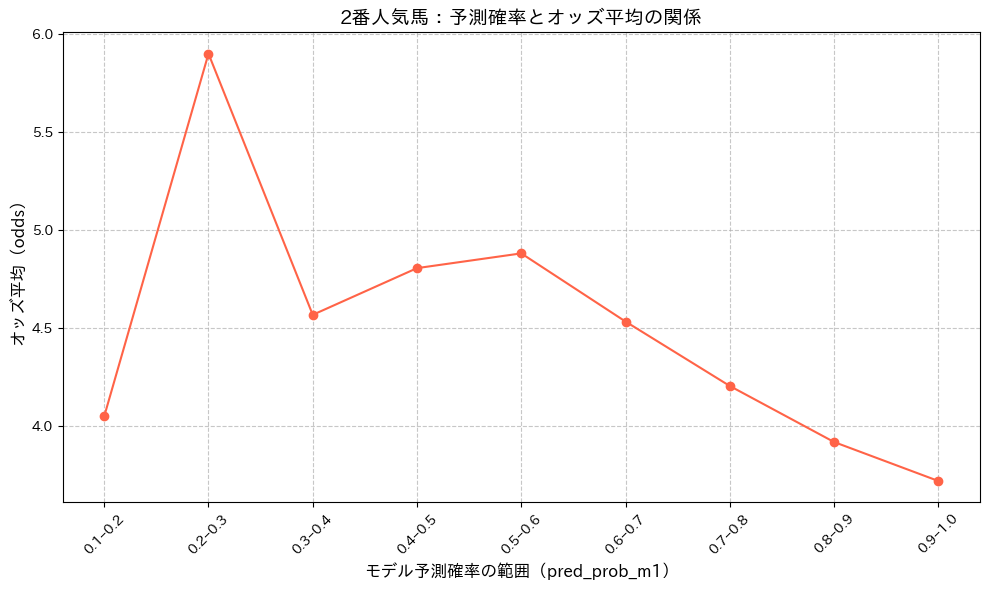

  prob_bin  „Çµ„É≥„Éó„É´Êï∞     „Ç™„ÉÉ„Ç∫Âπ≥Âùá
0  0.0‚Äì0.1      0       NaN
1  0.1‚Äì0.2      8  4.050000
2  0.2‚Äì0.3     18  5.900000
3  0.3‚Äì0.4     34  4.567647
4  0.4‚Äì0.5    102  4.805882
5  0.5‚Äì0.6    239  4.881172
6  0.6‚Äì0.7    402  4.533333
7  0.7‚Äì0.8    492  4.204675
8  0.8‚Äì0.9    320  3.918750
9  0.9‚Äì1.0     30  3.720000


In [41]:
# ‚ñº „Éë„É©„É°„Éº„ÇøÔºà‰ªªÊÑè„ÅÆ‰∫∫Ê∞ó„ÇíÊåáÂÆöÔºâ
target_popularity = 2

# ‚ñº 1. ÊåáÂÆö‰∫∫Ê∞ó„Å†„ÅëÊäΩÂá∫
df_fixed_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ‚ñº 2. „É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„Åß„Éì„É≥ÂàÜ„ÅëÔºà0.0„Äú1.0 „Çí 0.1Âàª„ÅøÔºâ
bins = np.arange(0, 1.01, 0.1)
labels = [f'{round(bins[i],2)}‚Äì{round(bins[i+1],2)}' for i in range(len(bins)-1)]
df_fixed_pop['prob_bin'] = pd.cut(df_fixed_pop['pred_prob_m1'], bins=bins, labels=labels, include_lowest=True)

# ‚ñº 3. ÂêÑ„Éì„É≥„Åî„Å®„ÅÆ„Ç™„ÉÉ„Ç∫Âπ≥Âùá„ÇíË®àÁÆó
odds_stats = (
    df_fixed_pop.groupby('prob_bin')
    .agg(
        „Çµ„É≥„Éó„É´Êï∞=('odds', 'count'),
        „Ç™„ÉÉ„Ç∫Âπ≥Âùá=('odds', 'mean')
    )
    .reset_index()
)

# ‚ñº 4. „Ç∞„É©„ÉïË°®Á§∫
plt.figure(figsize=(10, 6))
plt.plot(odds_stats['prob_bin'], odds_stats['„Ç™„ÉÉ„Ç∫Âπ≥Âùá'], marker='o', linestyle='-', color='tomato')
plt.xlabel('„É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„ÅÆÁØÑÂõ≤Ôºàpred_prob_m1Ôºâ', fontsize=12)
plt.ylabel('„Ç™„ÉÉ„Ç∫Âπ≥ÂùáÔºàoddsÔºâ', fontsize=12)
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞óÈ¶¨Ôºö‰∫àÊ∏¨Á¢∫Áéá„Å®„Ç™„ÉÉ„Ç∫Âπ≥Âùá„ÅÆÈñ¢‰øÇ', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ‚ñº Ë°®„ÅÆÂá∫ÂäõÔºàÁ¢∫Ë™çÁî®Ôºâ
print(odds_stats)

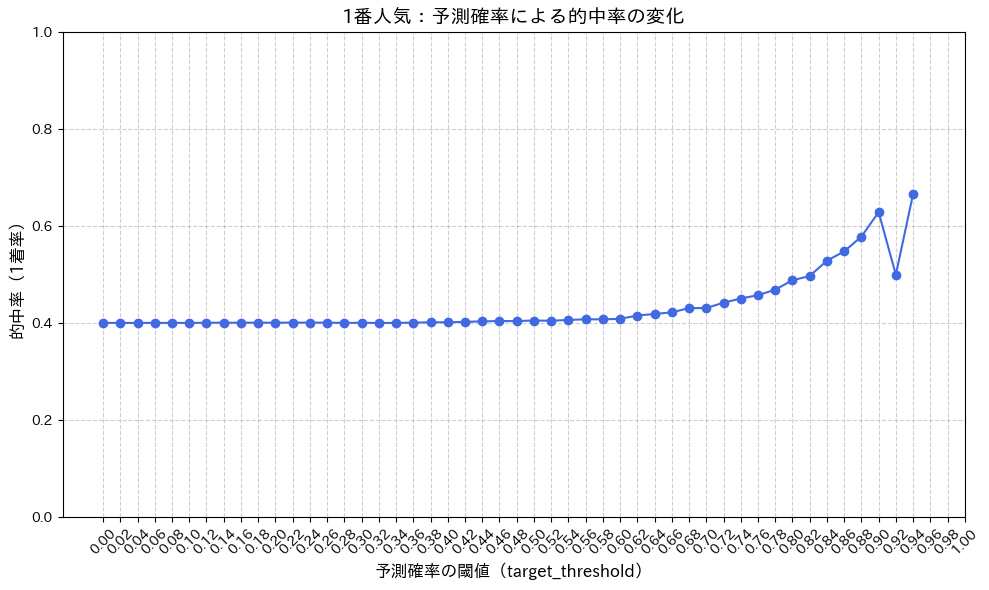

In [343]:
import numpy as np
import matplotlib.pyplot as plt

# ‚ñº ÊåáÂÆö„Åô„Çã‰∫∫Ê∞ó
target_popularity = 1

# ‚ñº „Éá„Éº„Çø„ÅÆ„Éï„Ç£„É´„ÇøÔºöÊåáÂÆö‰∫∫Ê∞ó„ÅÆÈ¶¨„Å†„Åë
df_target_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ‚ñº ÈñæÂÄ§„ÅÆÁØÑÂõ≤Ôºà0.0„Äú1.0 „Çí 0.05Âàª„Åø„ÅßÔºâ
thresholds = np.arange(0.0, 1.01, 0.02)

hit_rates = []  # ÁöÑ‰∏≠Áéá„É™„Çπ„Éà

for thresh in thresholds:
    df_thresh = df_target_pop[df_target_pop['pred_prob_m1'] >= thresh]
    total = len(df_thresh)
    if total == 0:
        hit_rate = np.nan  # „Éá„Éº„Çø„Å™„Åó„ÅÆÂ†¥Âêà„ÅØNaN
    else:
        hits = (df_thresh['finish_rank'] == 1).sum()
        hit_rate = hits / total
    hit_rates.append(hit_rate)

# ‚ñº „Ç∞„É©„Éï„ÅÆÊèèÁîª
plt.figure(figsize=(10, 6))
plt.plot(thresholds, hit_rates, marker='o', linestyle='-', color='royalblue')
plt.xlabel('‰∫àÊ∏¨Á¢∫Áéá„ÅÆÈñæÂÄ§Ôºàtarget_thresholdÔºâ', fontsize=12)
plt.ylabel('ÁöÑ‰∏≠ÁéáÔºà1ÁùÄÁéáÔºâ', fontsize=12)
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞óÔºö‰∫àÊ∏¨Á¢∫Áéá„Å´„Çà„ÇãÁöÑ‰∏≠Áéá„ÅÆÂ§âÂåñ', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.round(thresholds, 2), rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


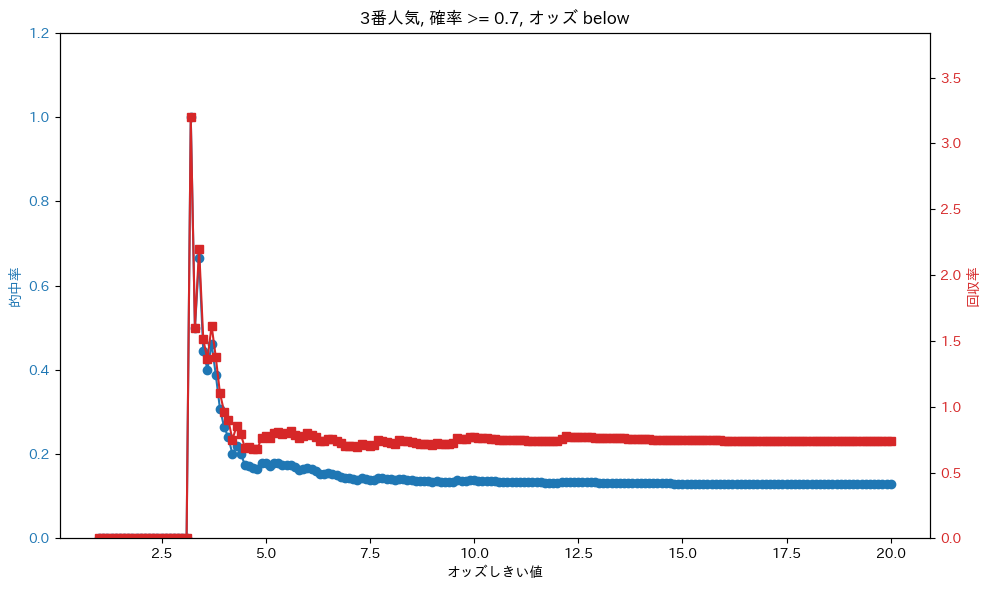

In [121]:
# ‚ñº „Éë„É©„É°„Éº„ÇøË®≠ÂÆö
target_popularity = 3
prob_threshold = 0.7
odds_min = 1.0
odds_max = 20
odds_step = 0.1
filter_type = 'below'  # 'below' or 'above'

# ‚ñº Ë©≤ÂΩì‰∫∫Ê∞ó„Å†„Åë„Å´Áµû„Çã
df_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ‚ñº „É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„ÅåÈ´ò„ÅÑÈ¶¨„ÇíÊäΩÂá∫
df_high_prob = df_pop[df_pop['pred_prob_m1'] >= prob_threshold].copy()

# ‚ñº ÁµêÊûúË®òÈå≤„É™„Çπ„Éà
odds_thresholds = []
hit_rates = []
rois = []
sample_sizes = []

# ‚ñº „Ç™„ÉÉ„Ç∫„Åó„Åç„ÅÑÂÄ§„ÇíÂ§âÂåñ„Åï„Åõ„Å™„Åå„ÇâÈõÜË®à
odds_range = np.arange(odds_min, odds_max + odds_step, odds_step)

for threshold in odds_range:
    if filter_type == 'below':
        subset = df_high_prob[df_high_prob['odds'] <= threshold].copy()
    elif filter_type == 'above':
        subset = df_high_prob[df_high_prob['odds'] > threshold].copy()
    else:
        raise ValueError("filter_type „ÅØ 'below' „Åæ„Åü„ÅØ 'above' „Å´„Åó„Å¶„Åè„Å†„Åï„ÅÑ")

    sample_size = len(subset)
    hit_count = (subset['finish_rank'] == 1).sum()
    return_sum = subset.loc[subset['finish_rank'] == 1, 'odds'].sum()

    hit_rate = hit_count / sample_size if sample_size > 0 else 0
    roi = return_sum / sample_size if sample_size > 0 else 0

    # ÁµêÊûúË®òÈå≤
    odds_thresholds.append(threshold)
    hit_rates.append(hit_rate)
    rois.append(roi)
    sample_sizes.append(sample_size)

# ‚ñº „Ç∞„É©„ÉïË°®Á§∫ÔºàÁöÑ‰∏≠Áéá & ÂõûÂèéÁéá„ÅÆ2Ëª∏Ôºâ
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('„Ç™„ÉÉ„Ç∫„Åó„Åç„ÅÑÂÄ§')
ax1.set_ylabel('ÁöÑ‰∏≠Áéá', color=color1)
ax1.plot(odds_thresholds, hit_rates, color=color1, label='ÁöÑ‰∏≠Áéá', marker='o')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, max(hit_rates) * 1.2)

# ‚ñº ÂõûÂèéÁéá„ÅÆËª∏
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('ÂõûÂèéÁéá', color=color2)
ax2.plot(odds_thresholds, rois, color=color2, label='ÂõûÂèéÁéá', marker='s')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, max(rois) * 1.2)

# ‚ñº „Çø„Ç§„Éà„É´„ÉªÂá°‰æã
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞ó, Á¢∫Áéá >= {prob_threshold}, „Ç™„ÉÉ„Ç∫ {filter_type}')
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig("C:\\Users\\ryo\\Downloads\\plot.png")
plt.show()


C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layo

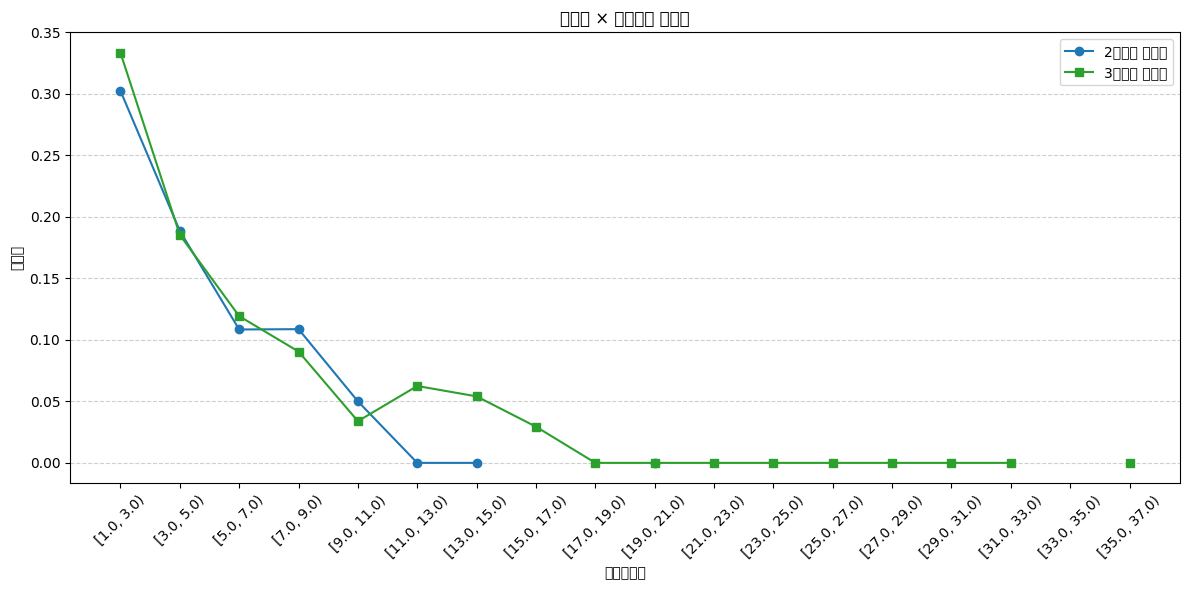

C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 31684 (\N{CJK UNIFIED IDEOGRAPH-7BC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22258 (\N{CJK UNIFIED IDEOGRAPH-56F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missin

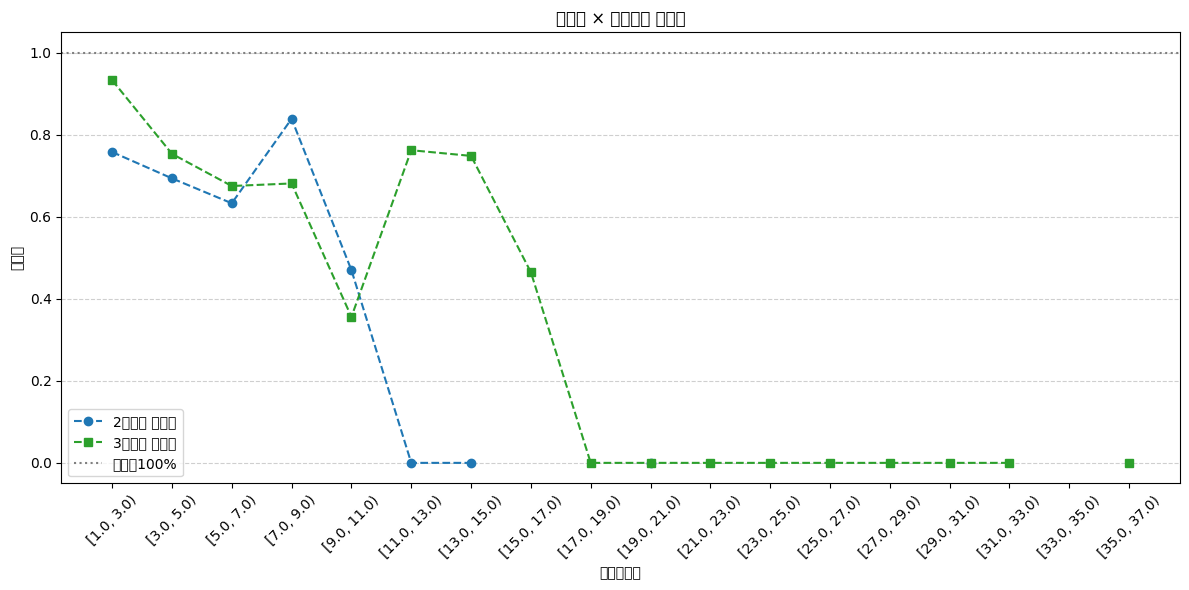

In [39]:

# -------- „Éë„É©„É°„Éº„Çø --------
odds_bins = np.arange(1.0, 51.0, 2.0)  # „Ç™„ÉÉ„Ç∫„Çí2Âàª„Åø„ÅßÂàÜÂâ≤
target_popularities = [2, 3]           # ÊØîËºÉ„Åó„Åü„ÅÑ‰∫∫Ê∞ó

# -------- „Éá„Éº„ÇøÂèéÈõÜ --------
plot_data = {}

for pop in target_popularities:
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    if df_pop.empty:
        continue

    df_pop['odds_bin'] = pd.cut(df_pop['odds'], bins=odds_bins, right=False)
    df_pop['hit'] = (df_pop['finish_rank'] == 1).astype(int)
    df_pop['return'] = df_pop['odds'] * df_pop['hit']

    stats = (
        df_pop.groupby('odds_bin')
        .agg(
            sample_size=('hit', 'count'),
            hit_count=('hit', 'sum'),
            return_sum=('return', 'sum')
        )
        .reset_index()
    )

    stats['hit_rate'] = stats['hit_count'] / stats['sample_size']
    stats['roi'] = stats['return_sum'] / stats['sample_size']
    stats['odds_bin_str'] = stats['odds_bin'].astype(str)
    plot_data[pop] = stats

# -------- ÂÖ±ÈÄöË®≠ÂÆö --------
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple']
markers = ['o', 's', 'D', '^', 'v']

# -------- „Ç∞„É©„Éï‚ë†ÔºöÁöÑ‰∏≠Áéá --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['hit_rate'],
             label=f'{pop}Áï™‰∫∫Ê∞ó ÁöÑ‰∏≠Áéá',
             color=colors[i % len(colors)], marker=markers[i % len(markers)])

plt.xlabel('„Ç™„ÉÉ„Ç∫ÁØÑÂõ≤')
plt.ylabel('ÁöÑ‰∏≠Áéá')
plt.title('‰∫∫Ê∞óÂà• √ó „Ç™„ÉÉ„Ç∫Âà• ÁöÑ‰∏≠Áéá')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------- „Ç∞„É©„Éï‚ë°ÔºöÂõûÂèéÁéá --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['roi'],
             label=f'{pop}Áï™‰∫∫Ê∞ó ÂõûÂèéÁéá',
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='--')

plt.xlabel('„Ç™„ÉÉ„Ç∫ÁØÑÂõ≤')
plt.ylabel('ÂõûÂèéÁéá')
plt.title('‰∫∫Ê∞óÂà• √ó „Ç™„ÉÉ„Ç∫Âà• ÂõûÂèéÁéá')
plt.xticks(rotation=45)
plt.axhline(y=1.0, color='gray', linestyle='dotted', label='ÂõûÂèéÁéá100%')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:43:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ê≠£Á≠îÁéá (accuracy): 0.6608
Ê∑∑ÂêåË°åÂàó:
 [[ 17 114]
 [ 21 246]]
ÂàÜÈ°û„É¨„Éù„Éº„Éà:
               precision    recall  f1-score   support

           0       0.45      0.13      0.20       131
           1       0.68      0.92      0.78       267

    accuracy                           0.66       398
   macro avg       0.57      0.53      0.49       398
weighted avg       0.61      0.66      0.59       398


-------------------------


‚ñº Ë©ï‰æ°ÁµêÊûúÔºà3Áï™‰∫∫Ê∞óÔºâ
  ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞       : 398
  „É¢„Éá„É´„Åå1„Å®‰∫àÊ∏¨„Åó„ÅüÊï∞ : 360
  ÁöÑ‰∏≠Êï∞Ôºà1ÁùÄÔºâ         : 48
  Êâï„ÅÑÊàª„ÅóÂêàË®à           : 271.90
  ÂõûÂèéÁéá                 : 0.7553Ôºà75.53%Ôºâ
‚ñº Á¢∫Áéá„ÅßË≥ºÂÖ•Âà§Êñ≠Ôºà„Åó„Åç„ÅÑÂÄ§ = 0.7 Ôºâ
ÂØæË±°‰∫∫Ê∞ó           : 3Áï™‰∫∫Ê∞ó
ÂÖ®‰Ωì„É¨„Éº„ÇπÊï∞       : 398
Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞   : 42
ÁöÑ‰∏≠Êï∞             : 12
ÁöÑ‰∏≠Áéá             : 0.2857Ôºà28.57%Ôºâ
ÂõûÂèéÁéá             : 1.1595Ôºà115.95%Ôºâ
          feature  importance
2  pop3_pred_prob    2.988739

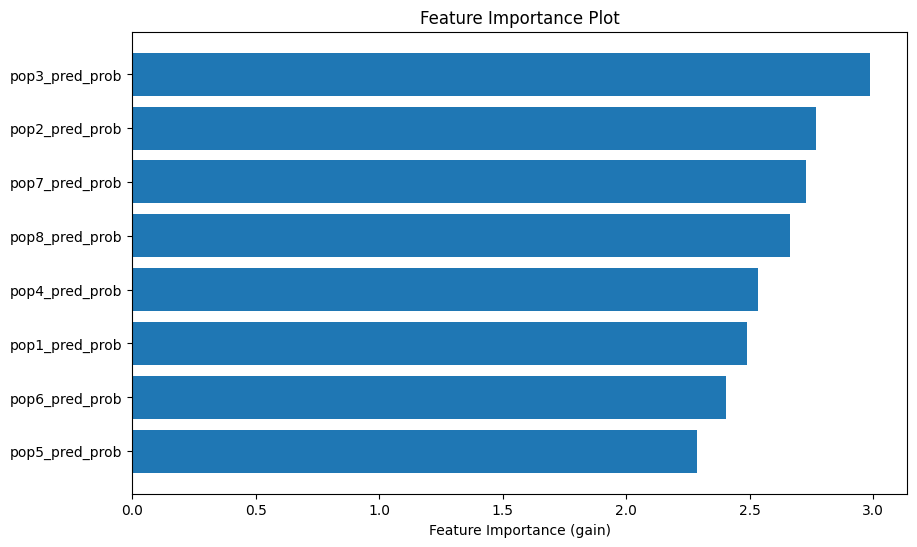

In [205]:
# 1. ‰∫∫Ê∞ó„ÅåÈáçË§á„Åó„Å¶„ÅÑ„Çã„É¨„Éº„ÇπID„ÇíÁâπÂÆö
pop_counts = full_pred_df.groupby(['race_id', 'popularity']).size().reset_index(name='count')
duplicated_pops = pop_counts[pop_counts['count'] > 1]['race_id'].unique()

# 2. full_pred_df „Åã„ÇâÈô§Â§ñÔºàÈáçË§á‰∫∫Ê∞ó„ÇíÂê´„ÇÄ„É¨„Éº„Çπ„ÅØÂÖ®Èô§Â§ñÔºâ
clean_df = full_pred_df[~full_pred_df['race_id'].isin(duplicated_pops)].copy()

# 3. ‰∫∫Ê∞ó„Åî„Å®„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„ÇíÊ®™ÊåÅ„Å°„Å´„Åô„ÇãÔºàpivotÔºâ
feature_df = clean_df.copy()
feature_df['pop_col'] = feature_df['popularity'].apply(lambda x: f'pop{x}_pred_prob')
X_all = feature_df.pivot(index='race_id', columns='pop_col', values='pred_prob_m1').reset_index()

# 4. „Çø„Éº„Ç≤„ÉÉ„Éà‰∫∫Ê∞ó„ÅÆÁõÆÁöÑÂ§âÊï∞‰ΩúÊàêÔºà‰æãÔºö3Áï™‰∫∫Ê∞ó„Åå1ÁùÄ„Åã„Å©„ÅÜ„ÅãÔºâ
target_popularity = 3
y_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'finish_rank']].copy()
y_df['target'] = (y_df['finish_rank'] <= 4).astype(int)

# 5. Â≠¶ÁøíÁî®„Å´„Éû„Éº„Ç∏
data = pd.merge(X_all, y_df[['race_id', 'target']], on='race_id', how='inner')

# 6. ÁâπÂæ¥Èáè„ÉªÁõÆÁöÑÂ§âÊï∞„Å´ÂàÜÂâ≤
X = data.drop(columns=['race_id', 'target'])
y = data['target']

# 7. „É¢„Éá„É´Â≠¶ÁøíÔºà‰æãÔºöXGBoostÔºâ
from sklearn.model_selection import train_test_split
import xgboost as xgb

# race_id „ÅÆÂÖàÈ†≠2Ê°Å„Åã„Çâ„ÄåÂπ¥„Äç„ÇíÊäΩÂá∫ÔºàÊñáÂ≠óÂàó„Å®„Åó„Å¶Âá¶ÁêÜÔºâ
data['year'] = data['race_id'].astype(str).str[:2]

# Â≠¶Áøí„Éá„Éº„ÇøÔºö2023Âπ¥Ôºà= '23'Ôºâ
train_data = data[data['year'] == '23']
X_train = train_data.drop(columns=['race_id', 'target', 'year'])
y_train = train_data['target']

# Ê§úË®º„Éá„Éº„ÇøÔºö2024Âπ¥Ôºà= '24'Ôºâ
val_data = data[data['year'] == '24']
X_val = val_data.drop(columns=['race_id', 'target', 'year'])
y_val = val_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ====== „Éë„É©„É°„Éº„ÇøÂÆöÁæ© ======
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'n_estimators': 100,
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

# ====== „É¢„Éá„É´ÂÆöÁæ© ======
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train)

# 8. Ë©ï‰æ°
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_val)

# „É¢„Éá„É´‰∫àÊ∏¨
y_pred = model.predict(X_val)

# X_val „Å´ race_id „Çí‰ªò‰∏éÔºàÂÖÉ„ÅÆ„Éá„Éº„Çø„Åã„ÇâÂèñÂæóÔºâ
X_val_with_preds = X_val.copy()
X_val_with_preds['race_id'] = data.loc[X_val.index, 'race_id'].values
X_val_with_preds['y_true'] = y_val.values
X_val_with_preds['y_pred'] = y_pred

# race_id Âçò‰Ωç„ÅßÈáçË§á„ÇíÈô§„ÅèÔºà1‰∫∫Ê∞ó„ÅÇ„Åü„Çä1Ë°åÔºâ
target_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'odds', 'finish_rank', 'popularity']].copy()

# ‰∫àÊ∏¨ÁµêÊûú„Å®Áµ±Âêà
eval_df = pd.merge(X_val_with_preds, target_df, on='race_id', how='left')

# ‚úÖ ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞ÔºàÈáçË§áÈô§„ÅÑ„Å¶„Ç´„Ç¶„É≥„ÉàÔºâ
total_races = eval_df['race_id'].nunique()

# ‚úÖ ‰∫àÊ∏¨„Åå1Ôºà=Ë≥ºÂÖ•ÂØæË±°Ôºâ„ÅÆ„É¨„Éº„Çπ„Å†„ÅëÊäΩÂá∫
bets = eval_df[eval_df['y_pred'] == 1].copy()
bets['hit'] = (bets['finish_rank'] == 1).astype(int)  # ÁöÑ‰∏≠ = 1ÁùÄ

# Ë≥ºÂÖ•Êï∞„ÄÅÁöÑ‰∏≠Êï∞„ÄÅÊâï„ÅÑÊàª„ÅóÂêàË®à
num_bets = len(bets)
num_hits = bets['hit'].sum()
total_return = (bets['odds'] * bets['hit']).sum()
roi = total_return / num_bets if num_bets > 0 else 0
# Ë©ï‰æ°ÊåáÊ®ô
acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Ê≠£Á≠îÁéá (accuracy): {acc:.4f}")
print("Ê∑∑ÂêåË°åÂàó:\n", cm)
print("ÂàÜÈ°û„É¨„Éù„Éº„Éà:\n", report)
print("\n-------------------------\n")
# ‚úÖ Âá∫Âäõ
print(f"\n‚ñº Ë©ï‰æ°ÁµêÊûúÔºà{target_popularity}Áï™‰∫∫Ê∞óÔºâ")
print(f"  ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞       : {total_races}")
print(f"  „É¢„Éá„É´„Åå1„Å®‰∫àÊ∏¨„Åó„ÅüÊï∞ : {num_bets}")
print(f"  ÁöÑ‰∏≠Êï∞Ôºà1ÁùÄÔºâ         : {num_hits}")
print(f"  Êâï„ÅÑÊàª„ÅóÂêàË®à           : {total_return:.2f}")
print(f"  ÂõûÂèéÁéá                 : {roi:.4f}Ôºà{roi:.2%}Ôºâ")

# ====== „Éë„É©„É°„Éº„ÇøË®≠ÂÆö ======
prob_threshold = 0.7      # Ë≥ºÂÖ•„Åô„ÇãÁ¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà‰æãÔºö0.7Ôºâ
odds_threshold = 4.5      # Ë≥ºÂÖ•„Åô„Çã„Ç™„ÉÉ„Ç∫„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà‰æãÔºö3.0Ôºâ

# ====== ‰∫àÊ∏¨Á¢∫Áéá„ÅÆÂèñÂæó ======
y_proba = model.predict_proba(X_val)[:, 1]  # „ÇØ„É©„Çπ1Ôºà1ÁùÄ„Å´„Å™„ÇãÁ¢∫ÁéáÔºâ„ÅÆ„Åø

# ====== „Éá„Éº„ÇøÁµêÂêà ======
# X_val „Å´„ÅØ race_id „Å™„Å©„ÅÆÊÉÖÂ†±„Åå„Å™„ÅÑ„ÅÆ„Åß„ÄÅfeature_df „Åã„Çâ race_id, odds, finish_rank „ÇíÂèñÂæó
val_df_with_info = eval_df[eval_df['popularity'] == target_popularity].copy()
val_df_with_info = val_df_with_info.reset_index(drop=True)  # Âøµ„ÅÆ„Åü„ÇÅÊï¥Âàó

val_df_with_info['pred_prob'] = y_proba
val_df_with_info['hit'] = (val_df_with_info['finish_rank'] == 1).astype(int)

# ====== Ë≥ºÂÖ•„Åô„Çã„É¨„Éº„ÇπÔºàÁ¢∫Áéá„ÅåÈ´ò„ÅÑ„ÇÇ„ÅÆÔºâ ======
bets = val_df_with_info[
    (val_df_with_info['pred_prob'] >= prob_threshold) &
    (val_df_with_info['odds'] <= odds_threshold)
].copy()

# ====== ÂõûÂèéÁéá„ÉªÁöÑ‰∏≠ÁéáË®àÁÆó ======
race_count_total = len(val_df_with_info)
race_count_bet = len(bets)
hit_count = bets['hit'].sum()
hit_rate = hit_count / race_count_bet if race_count_bet > 0 else 0
total_return = bets.loc[bets['hit'] == 1, 'odds'].sum()
roi = total_return / race_count_bet if race_count_bet > 0 else 0

# ====== ÁµêÊûúË°®Á§∫ ======
print("‚ñº Á¢∫Áéá„ÅßË≥ºÂÖ•Âà§Êñ≠Ôºà„Åó„Åç„ÅÑÂÄ§ =", prob_threshold, "Ôºâ")
print(f"ÂØæË±°‰∫∫Ê∞ó           : {target_popularity}Áï™‰∫∫Ê∞ó")
print(f"ÂÖ®‰Ωì„É¨„Éº„ÇπÊï∞       : {race_count_total}")
print(f"Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞   : {race_count_bet}")
print(f"ÁöÑ‰∏≠Êï∞             : {hit_count}")
print(f"ÁöÑ‰∏≠Áéá             : {hit_rate:.4f}Ôºà{hit_rate:.2%}Ôºâ")
print(f"ÂõûÂèéÁéá             : {roi:.4f}Ôºà{roi:.2%}Ôºâ")

# ====== „Ç™„Éó„Ç∑„Éß„É≥ÔºöCSVÂá∫Âäõ ======
bets.to_csv(f'pop{target_popularity}_prob{prob_threshold}_bets.csv', index=False, encoding='cp932')

import matplotlib.pyplot as plt
import xgboost as xgb

# 1. ÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶„ÅÆÂèñÂæóÔºàgain, weight, cover „Å™„Å©„ÅÑ„Çç„ÅÑ„Çç„ÅÇ„Çä„Åæ„Åô„Åå„ÄÅ'gain'„Åå„Çà„Åè‰Ωø„Çè„Çå„Åæ„ÅôÔºâ
importance = model.get_booster().get_score(importance_type='gain')

# 2. ËæûÊõ∏ ‚Üí DataFrame „Å´Â§âÊèõ„Åó„Å¶Ë¶ã„ÇÑ„Åô„Åè
import pandas as pd

importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print(importance_df)

# 3. Ê£í„Ç∞„É©„Éï„ÅßÂèØË¶ñÂåñ
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()  # ÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑÈ†Ü„Å´Ë°®Á§∫
plt.xlabel('Feature Importance (gain)')
plt.title('Feature Importance Plot')
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36092 (\N{CJK UNIFIED IDEOGRAPH-8CFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.pr

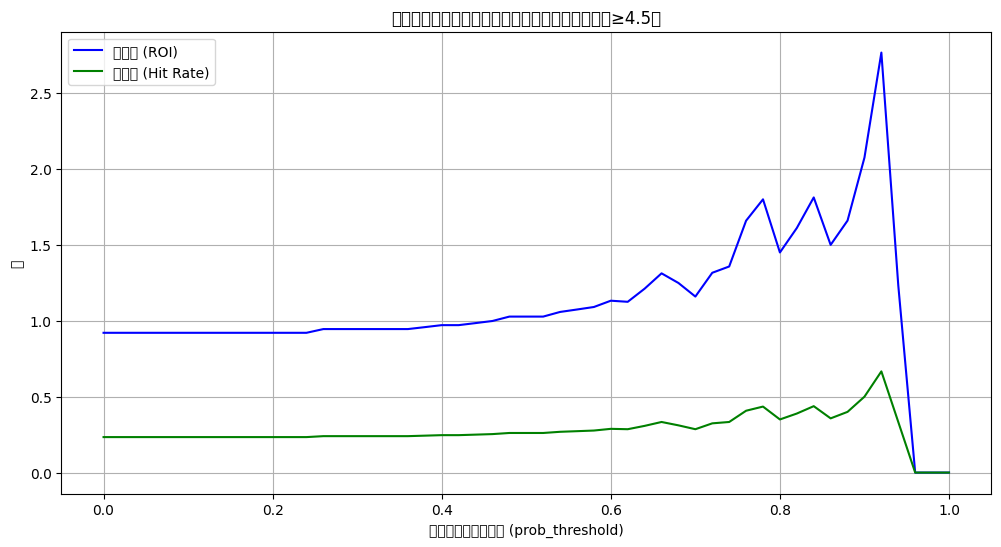

C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35937 (\N{CJK UNIFIED IDEOGRAPH-8C61}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canva

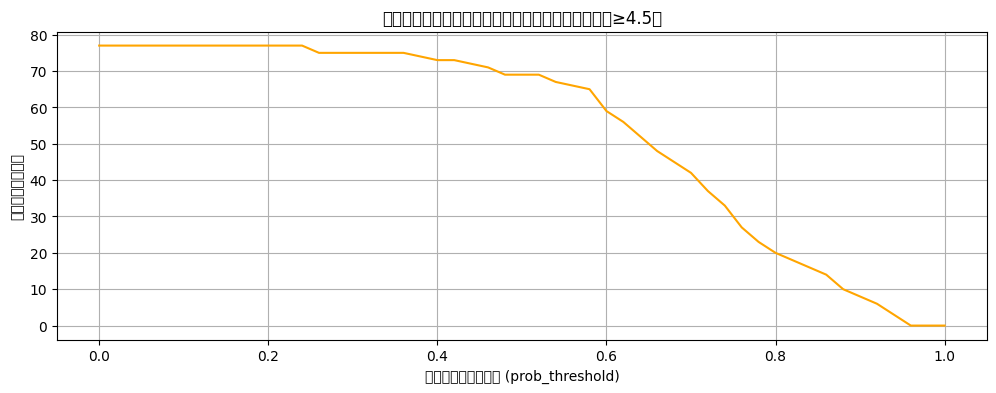

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà0„Äú1Ôºâ
thresholds = np.arange(0.0, 1.01, 0.02)

roi_list = []
hit_rate_list = []
bet_count_list = []

for thr in thresholds:
    # Á¢∫Áéá„Å®„Ç™„ÉÉ„Ç∫‰∏°Êñπ„ÅÆÊù°‰ª∂„ÅßË≥ºÂÖ•Âà§Êñ≠
    bets_thr = val_df_with_info[
        (val_df_with_info['pred_prob'] >= thr) &
        (val_df_with_info['odds'] <= odds_threshold)
    ].copy()
    
    num_bets = len(bets_thr)
    if num_bets > 0:
        hits = bets_thr['hit'].sum()
        hit_rate = hits / num_bets
        total_return = bets_thr.loc[bets_thr['hit'] == 1, 'odds'].sum()
        roi = total_return / num_bets
    else:
        hit_rate = 0
        roi = 0
    
    roi_list.append(roi)
    hit_rate_list.append(hit_rate)
    bet_count_list.append(num_bets)

# „Ç∞„É©„ÉïÊèèÁîª
plt.figure(figsize=(12,6))
plt.plot(thresholds, roi_list, label='ÂõûÂèéÁéá (ROI)', color='blue')
plt.plot(thresholds, hit_rate_list, label='ÁöÑ‰∏≠Áéá (Hit Rate)', color='green')
plt.xlabel('Ë≥ºÂÖ•Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§ (prob_threshold)')
plt.ylabel('Áéá')
plt.title(f'Ë≥ºÂÖ•Á¢∫Áéá„Åó„Åç„ÅÑÂÄ§„Åî„Å®„ÅÆÂõûÂèéÁéá„Å®ÁöÑ‰∏≠ÁéáÔºà„Ç™„ÉÉ„Ç∫‚â•{odds_threshold}Ôºâ')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(thresholds, bet_count_list, label='Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞', color='orange')
plt.xlabel('Ë≥ºÂÖ•Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§ (prob_threshold)')
plt.ylabel('Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞')
plt.title(f'Ë≥ºÂÖ•Á¢∫Áéá„Åó„Åç„ÅÑÂÄ§„Åî„Å®„ÅÆË≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞Ôºà„Ç™„ÉÉ„Ç∫‚â•{odds_threshold}Ôºâ')
plt.grid(True)
plt.show()
